# Callin Switzer
### 9 Nov 2018
___
### - Train Dense, Feedforward Neural Network with Keras


___

In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from matplotlib.ticker import ScalarFormatter
import os
import pandas as pd
import time
from datetime import datetime
import sys
import seaborn as sns
import scipy.io
import subprocess
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler  
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
print("TensorFlow successfully installed.")
if tf.test.is_built_with_cuda():
    print("The installed version of TensorFlow includes GPU support.")
print(sys.version, "\n")
now = datetime.now()
print("last run on " + str(now))

# define directories
baseDir = os.getcwd()
dataDir = r'D:\MothSimulations\11c-AggressiveManeuver\Qstore\hws_am_con'
figDir = r'D:\Dropbox\AcademiaDropbox\mothMachineLearning_dataAndFigs\Figs'
dataOutput = r'D:\Dropbox\AcademiaDropbox\mothMachineLearning_dataAndFigs\DataOutput'
savedModels = r'D:\Dropbox\AcademiaDropbox\mothMachineLearning_dataAndFigs\savedModels'

if not os.path.exists(dataOutput):
    os.mkdir(dataOutput)
if not os.path.exists(savedModels):
    os.mkdir(savedModels)


C:\Users\calli\Anaconda3\envs\deeplearning\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


TensorFlow successfully installed.
The installed version of TensorFlow includes GPU support.
3.6.4 |Anaconda custom (64-bit)| (default, Jan 16 2018, 10:22:32) [MSC v.1900 64 bit (AMD64)] 

last run on 2018-11-09 13:34:18.451757


# Make training and test set

In [2]:
# load dataset
trainDF2 = pd.read_csv(os.path.join(dataOutput, "smallDF.csv"))
trainDF2.head()

,simNum,timestep,F,alpha,phi_0,phi_99,phi_dot_0,phi_dot_99,tau,theta_0,...,x_0,x_99,x_dot_0,x_dot_99,y_0,y_99,y_dot_0,y_dot_99,Fx,Fy
0,0,0,38304.433962,5.340270,3.926991,3.869604,0.000000,-5.674295,10963.268558,0.785398,...,0.000000,6.853314,0.000100,683.734561,0.000000,-1.298536,0.000100,-133.752363,22501.211072,-30998.792903
1,0,1,34264.536249,2.465501,3.948428,4.019544,2.009397,5.425513,72580.767201,0.768478,...,-0.019322,-6.079672,-0.145396,-606.129200,2.520087,6.366770,250.908304,120.273149,-26727.166452,21441.012519
2,0,2,12045.791872,4.573819,3.966608,3.933017,-0.124272,-2.775517,93435.855346,0.768515,...,0.509507,2.986736,52.490438,193.914740,4.834518,2.470847,-18.848146,-211.050011,-1663.845687,-11930.327714
3,0,3,35562.854879,0.767089,4.000007,4.111777,3.434103,7.246049,-96088.338473,0.773977,...,-0.836633,-4.334782,-187.046694,-157.064454,6.838940,17.508792,218.755312,844.589134,25602.909376,24682.132781
4,0,4,20856.636628,2.424378,4.009324,3.995061,-2.309667,0.686804,-27142.805375,0.815904,...,0.429770,2.895126,313.730247,-65.350386,8.392823,6.771320,-58.222983,-102.458917,-15718.389244,13708.812166


In [3]:
# make dataset
X = trainDF2.loc[:, ["x_0", "y_0", "phi_0", "theta_0", 
                    "x_99", "y_99", "phi_99", "theta_99", 
                   "x_dot_0", "y_dot_0", "phi_dot_0", "theta_dot_0"]]

Y = trainDF2.loc[:, ["Fx", "Fy", "tau", "x_dot_99", "y_dot_99", 
                    "phi_dot_99", "theta_dot_99"] ]

In [4]:
X.head()

,x_0,y_0,phi_0,theta_0,x_99,y_99,phi_99,theta_99,x_dot_0,y_dot_0,phi_dot_0,theta_dot_0
0,0.000000,0.000000,3.926991,0.785398,6.853314,-1.298536,3.869604,0.746382,0.000100,0.000100,0.000000,0.000000
1,-0.019322,2.520087,3.948428,0.768478,-6.079672,6.366770,4.019544,0.940422,-0.145396,250.908304,2.009397,0.087406
2,0.509507,4.834518,3.966608,0.768515,2.986736,2.470847,3.933017,0.868402,52.490438,-18.848146,-0.124272,-1.029996
3,-0.836633,6.838940,4.000007,0.773977,-4.334782,17.508792,4.111777,0.747358,-187.046694,218.755312,3.434103,2.037211
4,0.429770,8.392823,4.009324,0.815904,2.895126,6.771320,3.995061,0.761962,313.730247,-58.222983,-2.309667,-0.673328


In [5]:
Y.head()

,Fx,Fy,tau,x_dot_99,y_dot_99,phi_dot_99,theta_dot_99
0,22501.211072,-30998.792903,10963.268558,683.734561,-133.752363,-5.674295,-4.770986
1,-26727.166452,21441.012519,72580.767201,-606.129200,120.273149,5.425513,10.479995
2,-1663.845687,-11930.327714,93435.855346,193.914740,-211.050011,-2.775517,3.897680
3,25602.909376,24682.132781,-96088.338473,-157.064454,844.589134,7.246049,0.318982
4,-15718.389244,13708.812166,-27142.805375,-65.350386,-102.458917,0.686804,-1.304712


In [6]:
# test train split
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2, random_state = 123)

In [7]:
# scale data 
scalerX = StandardScaler()  
scalerY = StandardScaler()  

# Don't cheat - fit only on training data
scalerX.fit(Xtrain)  
scalerY.fit(Ytrain) 

Xtrain_scaled = scalerX.transform(Xtrain)  
Ytrain_scaled = scalerY.transform(Ytrain)  

# apply same transformation to test data
Xtest_scaled = scalerX.transform(Xtest)
Ytest_scaled = scalerY.transform(Ytest)

# Keras models

In [8]:
# import
from keras.layers import Input, Dense, Dropout, BatchNormalization
from keras.models import Model
from keras import regularizers

# Keras callcacks
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import keras.backend as K

Using TensorFlow backend.


In [9]:
K.clear_session()

In [10]:
# this is the original model
inputs = Input(shape=(Xtrain_scaled.shape[1],))
x = Dense(400, activation='tanh')(inputs)
x = Dense(400, activation='tanh')(x)
x = Dense(400, activation='tanh')(x)
x = Dense(16, activation='tanh')(x)
predictions = Dense(Ytrain_scaled.shape[1], activation='linear')(x)

# create model
model = Model(inputs=inputs, outputs=predictions)
model.compile(loss="mse", optimizer="adam", metrics = ['mse'])

earlystop = EarlyStopping(monitor='val_mean_squared_error', patience=50, 
                          verbose=1, mode='auto', min_delta = 0.001)

In [11]:
# start training
history = model.fit(Xtrain_scaled, Ytrain_scaled, validation_split = 0.3, 
                    verbose = 2, batch_size=2**14, epochs = 6, 
                    callbacks = [earlystop])

Train on 5600000 samples, validate on 2400000 samples
Epoch 1/6
 - 9s - loss: 0.0640 - mean_squared_error: 0.0640 - val_loss: 0.0119 - val_mean_squared_error: 0.0119
Epoch 2/6
 - 7s - loss: 0.0066 - mean_squared_error: 0.0066 - val_loss: 0.0045 - val_mean_squared_error: 0.0045
Epoch 3/6
 - 7s - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 4/6
 - 8s - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 5/6
 - 8s - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 6/6
 - 8s - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.0013 - val_mean_squared_error: 0.0013


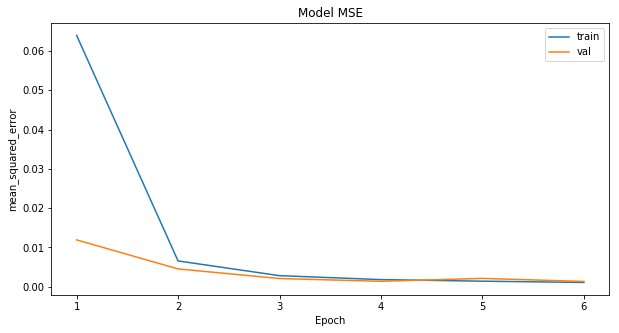

In [12]:
def plot_model_history(model_history, saveFig = False):
    fig, axs = plt.subplots(1,1,figsize=(10,5))
    # summarize history for accuracy
    axs.plot(range(1,len(model_history.history['mean_squared_error'])+1),
             model_history.history['mean_squared_error'])
    axs.plot(range(1,len(model_history.history['val_mean_squared_error'])+1),
             model_history.history['val_mean_squared_error'])
    axs.set_title('Model MSE')
    axs.set_ylabel('mean_squared_error')
    axs.set_xlabel('Epoch')
    axs.set_xticks(np.arange(1,len(model_history.history['val_mean_squared_error'])+1),
                   len(model_history.history['val_mean_squared_error'])/10)
    axs.legend(['train', 'val'], loc='best')
    if saveFig:
        fig.savefig(os.path.join(figDir, "ModelTraining.png"), dpi = 120, bbox_inches='tight')
    plt.show()
    
plot_model_history(history)

In [13]:
# load model that was trained for much longer
from keras.models import load_model
model = load_model(os.path.join(savedModels, 'my_model.h5'))

In [14]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 12)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 400)               5200      
_________________________________________________________________
dense_7 (Dense)              (None, 400)               160400    
_________________________________________________________________
dense_8 (Dense)              (None, 400)               160400    
_________________________________________________________________
dense_9 (Dense)              (None, 16)                6416      
_________________________________________________________________
dense_10 (Dense)             (None, 7)                 119       
Total params: 332,535
Trainable params: 332,535
Non-trainable params: 0
_________________________________________________________________


In [15]:
# get nonzero weights
wts = model.get_weights().copy()
nzwts = np.sum([np.nonzero(wts[ii].reshape(-1))[0].shape[0] for ii in range(len(wts))])
nzwts

332535

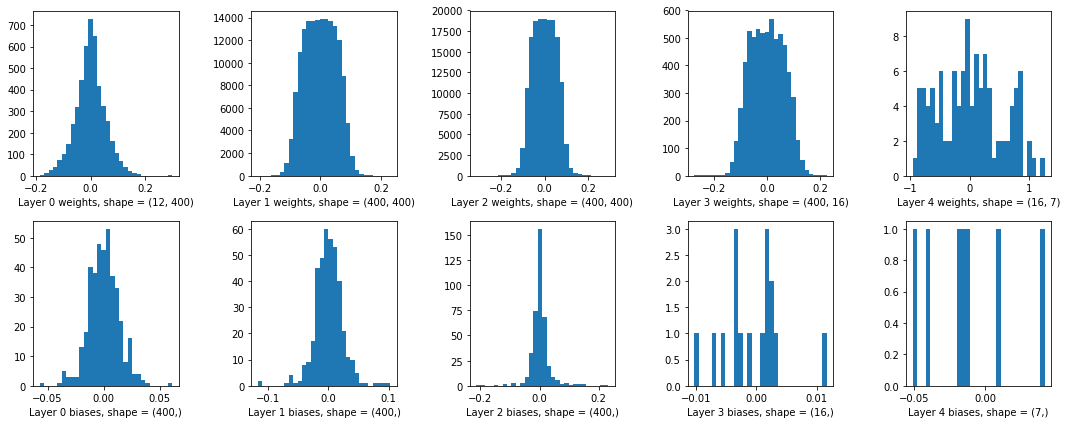

In [16]:
# show weights histograms
plt.close("all")
fig, axs = plt.subplots(2,5, figsize=np.array((15, 6)) , facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.3, wspace=0.3)
axs = axs.ravel(order = "F")

for ii in range(int(len(wts) / 2)):  
    jj= int(2*ii)
    axs[jj].hist(wts[jj].reshape(-1), bins = 30)
    axs[jj].set_xlabel("Layer " + str(int(jj/2)) + " weights" + ", shape = " + str(wts[jj].shape))
    axs[jj+1].hist(wts[jj+1], bins = 30)
    axs[jj+1].set_xlabel("Layer " + str(int(jj/2)) + " biases" + ", shape = " + str(wts[jj+1].shape))

plt.tight_layout()
plt.show()

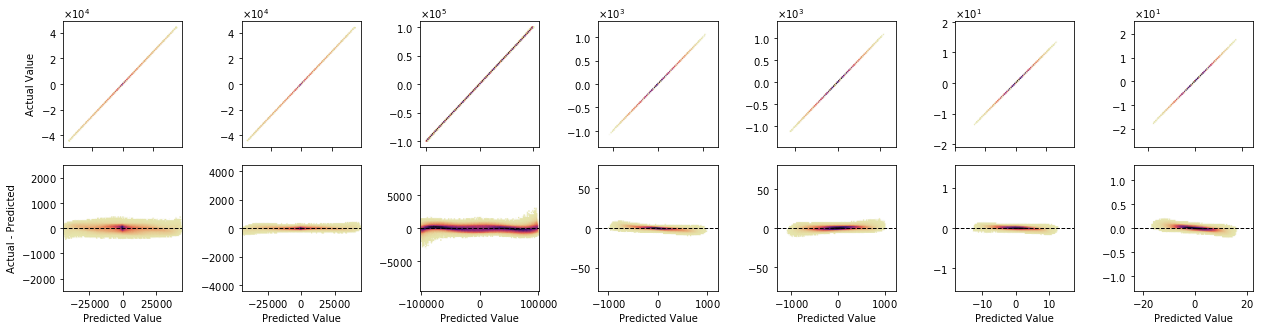

In [17]:
# predict on test set
nnpreds = model.predict(Xtest_scaled[ :])

# rescale
nnpreds_unscaled = scalerY.inverse_transform(nnpreds)

# show residuals
# combine residual and regular plots
plt.close("all")
fig, axs = plt.subplots(2,7, figsize=np.array((30, 8)) / 1.7, facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.1, wspace=0.5)
axs = axs.ravel()

# replace lightest colors with white
import matplotlib.colors
cmap = plt.cm.magma_r
cmaplist = np.array([cmap(i) for i in range(cmap.N)])
cmaplist[:,0:3] = np.divide(cmaplist[:, 0:3], 1.1)
cmaplist[0] = (1,1,1,0.5)
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('mcm',cmaplist, cmap.N)

for ii in range(len(Y.columns)):
    
    try:
        axs[ii].hexbin(y = Ytest.iloc[:,ii],x = nnpreds_unscaled[:,ii], gridsize = 150, cmap = cmap)
        axs[ii].yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        axs[ii].ticklabel_format(style='sci',  axis='y', scilimits=(3,4))
        axs[ii].axes.xaxis.set_ticklabels([])
        if(ii == 0):
            axs[ii].set_ylabel("Actual Value")
        axs[ii].set_title(nms2[ii])
        axs[ii].plot(Ytest.iloc[0:1000,ii], Ytest.iloc[0:1000,ii], 'grey', linewidth = 1, linestyle  = "--")
    except:
        pass

for ii in range(len(Y.columns)):
    jj = ii + len(Y.columns)
    
    try:
        axs[jj].hexbin(y = Ytest.iloc[:,ii] - nnpreds_unscaled[:,ii],x = nnpreds_unscaled[:,ii], gridsize = 150, cmap = cmap)
        axs[jj].set_xlabel("Predicted Value")
        axs[jj].xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        axs[jj].yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        mmin = np.min(Ytest.iloc[:,ii] - nnpreds_unscaled[:,ii])
        mmax = np.max(Ytest.iloc[:,ii] - nnpreds_unscaled[:,ii])
        
        upper = np.max([np.abs(mmin), np.abs(mmax)])
        axs[jj].set_ylim(-upper, upper)

        if(ii == 0):
            axs[jj].set_ylabel("Actual - Predicted")
        axs[jj].hlines(y = 0, xmin = np.min(nnpreds_unscaled[:,ii]), 
                       xmax = np.max(nnpreds_unscaled[:,ii]), linestyle =  "--", linewidth = 1)
    except:
        pass
plt.tight_layout()


In [18]:
# trim distribution of weights -- cut out middle 20%
for ii in np.arange(0, 7):
    qants = np.percentile(np.reshape(wts[ii], -1), q = (40, 60), )
    wts[ii][(wts[ii] > qants[0]) & (wts[ii] < qants[1])] = 0
    
# calculate number of nonzero weights
nzwts = np.sum([np.nonzero(wts[ii].reshape(-1))[0].shape[0] for ii in range(len(wts))])
nzwts

266055

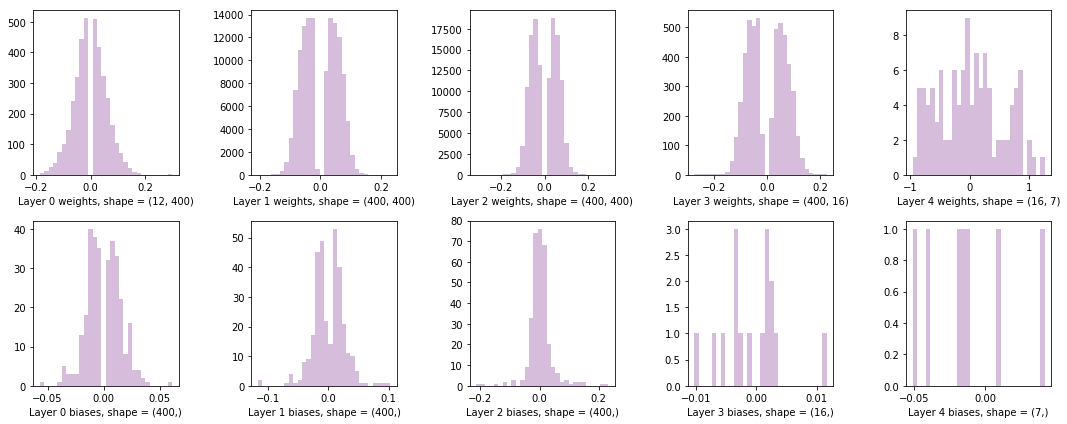

In [19]:
# show new histogram of weights (excluding the 0's)
# show weights histograms
plt.close("all")
fig, axs = plt.subplots(2,5, figsize=np.array((15, 6)) , facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.3, wspace=0.3)
axs = axs.ravel(order = "F")

for ii in range(int(len(wts) / 2)):  
    jj= int(2*ii)
    
    d1 = wts[jj].reshape(-1)
    axs[jj].hist(d1[d1!=0], bins = 30, facecolor = '#d6bddb' )
    axs[jj].set_xlabel("Layer " + str(int(jj/2)) + " weights" + ", shape = " + str(wts[jj].shape))

    d2 = wts[jj+1]
    axs[jj+1].hist(d2[d2!=0], bins = 30, facecolor = '#d6bddb')
    axs[jj+1].set_xlabel("Layer " + str(int(jj/2)) + " biases" + ", shape = " + str(wts[jj+1].shape))

plt.tight_layout()
plt.show()

In [20]:
# the validation.split is the last X% of the data
int(0.3*Xtrain_scaled.shape[0])
ValLoss = model.evaluate(Xtrain_scaled[-int(0.3*Xtrain_scaled.shape[0]):, :], 
                         Ytrain_scaled[-int(0.3*Xtrain_scaled.shape[0]):, :])
print(ValLoss[0])

2400000/2400000 [==============================] - 66s 28us/step
5.478470432955267e-05


In [21]:
# set new weights and calculate new loss
model.set_weights(wts)

In [22]:
ValLoss = model.evaluate(Xtrain_scaled[-int(0.3*Xtrain_scaled.shape[0]):, :], 
                         Ytrain_scaled[-int(0.3*Xtrain_scaled.shape[0]):, :])
print(ValLoss[0])

2400000/2400000 [==============================] - 66s 28us/step
0.0036997609308486185


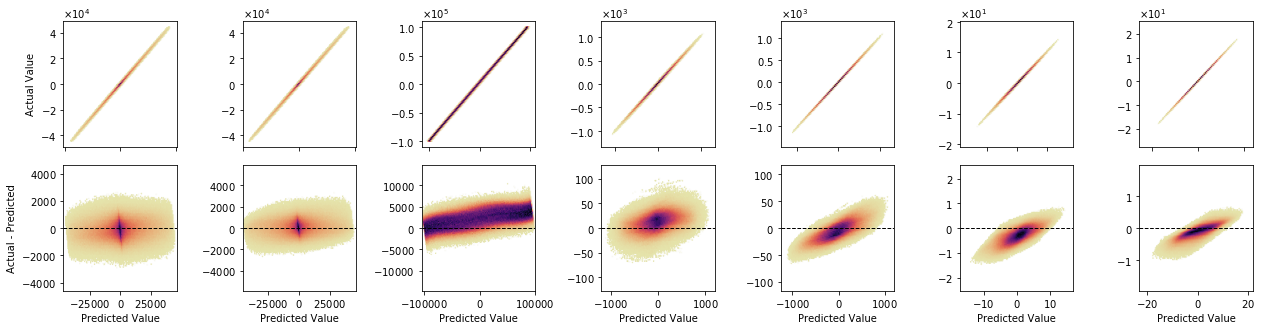

In [23]:
# predict on test set
nnpreds = model.predict(Xtest_scaled[ :])

# rescale
nnpreds_unscaled = scalerY.inverse_transform(nnpreds)

# show residuals
# combine residual and regular plots
plt.close("all")
fig, axs = plt.subplots(2,7, figsize=np.array((30, 8)) / 1.7, facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.1, wspace=0.5)
axs = axs.ravel()

# replace lightest colors with white
import matplotlib.colors
cmap = plt.cm.magma_r
cmaplist = np.array([cmap(i) for i in range(cmap.N)])
cmaplist[:,0:3] = np.divide(cmaplist[:, 0:3], 1.1)
cmaplist[0] = (1,1,1,0.5)
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('mcm',cmaplist, cmap.N)

for ii in range(len(Y.columns)):
    
    try:
        axs[ii].hexbin(y = Ytest.iloc[:,ii],x = nnpreds_unscaled[:,ii], gridsize = 150, cmap = cmap)
        axs[ii].yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        axs[ii].ticklabel_format(style='sci',  axis='y', scilimits=(3,4))
        axs[ii].axes.xaxis.set_ticklabels([])
        if(ii == 0):
            axs[ii].set_ylabel("Actual Value")
        axs[ii].set_title(nms2[ii])
        axs[ii].plot(Ytest.iloc[0:1000,ii], Ytest.iloc[0:1000,ii], 'grey', linewidth = 1, linestyle  = "--")
    except:
        pass

for ii in range(len(Y.columns)):
    jj = ii + len(Y.columns)
    
    try:
        axs[jj].hexbin(y = Ytest.iloc[:,ii] - nnpreds_unscaled[:,ii],x = nnpreds_unscaled[:,ii], gridsize = 150, cmap = cmap)
        axs[jj].set_xlabel("Predicted Value")
        axs[jj].xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        axs[jj].yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        mmin = np.min(Ytest.iloc[:,ii] - nnpreds_unscaled[:,ii])
        mmax = np.max(Ytest.iloc[:,ii] - nnpreds_unscaled[:,ii])
        
        upper = np.max([np.abs(mmin), np.abs(mmax)])
        axs[jj].set_ylim(-upper, upper)

        if(ii == 0):
            axs[jj].set_ylabel("Actual - Predicted")
        axs[jj].hlines(y = 0, xmin = np.min(nnpreds_unscaled[:,ii]), 
                       xmax = np.max(nnpreds_unscaled[:,ii]), linestyle =  "--", linewidth = 1)
    except:
        pass
plt.tight_layout()



___
## Show how MSE changes when more weights are set to 0
___

In [24]:
model = load_model(os.path.join(savedModels, 'my_model.h5'))
wts = model.get_weights()

In [25]:
# plot MSE as I remove more and more weights
lossList = []
for perc in np.arange(0, 51, 5): 

    for ii in np.arange(0, 8):
        qants = np.percentile(np.reshape(wts[ii], -1), q = (50 - perc, 50 + perc), )
        wts[ii][(wts[ii] > qants[0]) & (wts[ii] < qants[1])] = 0
        
    # set new weights and calculate new loss
    model.set_weights(wts)
    ValLoss = model.evaluate(Xtrain_scaled[-int(0.05*Xtrain_scaled.shape[0]):, :], 
                         Ytrain_scaled[-int(0.05*Xtrain_scaled.shape[0]):, :])
    lossList.append(ValLoss)
    
    print(ValLoss[0])
    

400000/400000 [==============================] - 11s 28us/step
5.4419546946592165e-05
400000/400000 [==============================] - 11s 28us/step
0.00046000533151673153
400000/400000 [==============================] - 11s 27us/step
0.003724626638768241
400000/400000 [==============================] - 11s 27us/step
0.016431262828931214
400000/400000 [==============================] - 10s 26us/step
0.04572638719305396
400000/400000 [==============================] - 10s 26us/step
0.12966801519155502
400000/400000 [==============================] - 11s 28us/step
0.3203652548503876
400000/400000 [==============================] - 11s 27us/step
0.5995226537775993
400000/400000 [==============================] - 11s 28us/step
0.9420370753383637
400000/400000 [==============================] - 11s 28us/step
1.212747404150963
400000/400000 [==============================] - 11s 28us/step
1.0014361709022521


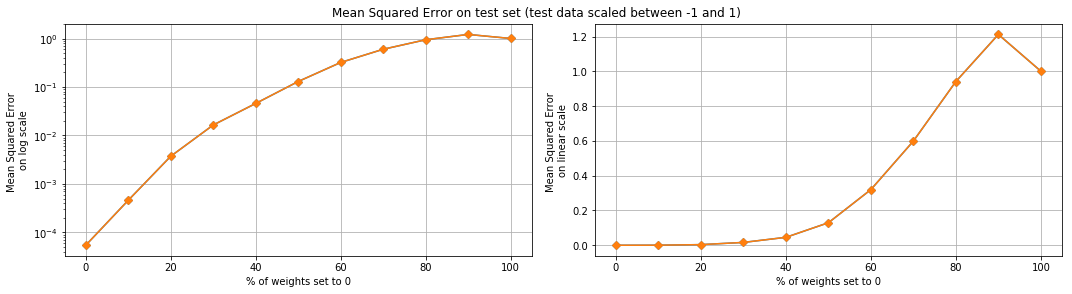

In [27]:

plt.close("all")
fig, axs = plt.subplots(1,2, figsize=np.array((15, 4)) , facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.5, wspace=0)
my_suptitle = fig.suptitle("Mean Squared Error on test set (test data scaled between -1 and 1)", y = 1.01)
axs = axs.ravel()


axs[0].plot(np.arange(0, 51, 5) * 2, lossList, '-D')
axs[0].set_xlabel("% of weights set to 0")
axs[0].set_ylabel("Mean Squared Error \non log scale")
axs[0].set_yscale('log')
axs[0].grid(True)


axs[1].plot(np.arange(0, 51, 5) * 2, lossList,  '-D')
axs[1].set_xlabel("% of weights set to 0")
axs[1].set_ylabel("Mean Squared Error \non linear scale")
axs[1].grid(True)
plt.tight_layout()
plt.savefig(os.path.join(figDir, "MSE_removingWeights.png"), dpi = 200,
            bbox_inches='tight', bbox_extra_artists=[my_suptitle] )
plt.show()

